## Imports & logging

In [1]:
import gensim
import gensim.downloader as api
import logging
from rdflib import Graph, Namespace, Literal
from rdflib.plugins.parsers import trig
import tempfile
import numpy as np
import pandas as pd
import random

from rdflib import URIRef
from rdflib.namespace import RDF
from rdflib.namespace import RDFS
from rdflib.namespace import SKOS
from tqdm import tqdm
from TqdmToLogger import TqdmToLogger
import matplotlib
import matplotlib.pyplot as plt
import json

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger()

tqdm.pandas()
tqdm_out = TqdmToLogger(logger, level=logging.INFO)

#TODO: use numpy for random stuff?
#https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.RandomState.html
random.seed(0)

c:\users\peter\python-projekte\master-thesis\venv\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
logger.setLevel(logging.INFO)

In [ ]:
logger.setLevel(logging.DEBUG)

In [31]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
#pd.reset_option('max_columns')
#pd.set_option('max_colwidth', None)

## Load dictionary

In [ ]:
gn = api.load('word2vec-google-news-300')

In [3]:
gw1 = api.load("glove-wiki-gigaword-100")

2021-01-08 19:56:05,641 : INFO : loading projection weights from C:\Users\Peter/gensim-data\glove-wiki-gigaword-100\glove-wiki-gigaword-100.gz
2021-01-08 19:56:37,395 : INFO : loaded (400000, 100) matrix from C:\Users\Peter/gensim-data\glove-wiki-gigaword-100\glove-wiki-gigaword-100.gz


In [4]:
wv = gw1

In [ ]:
gw3 = api.load("glove-wiki-gigaword-300")

## Load graph

### KBpedia

In [ ]:
kb = Graph()
kb.parse("C:/Users/Peter/gensim-data/KBpedia/kbpedia_reference_concepts.n3", format="n3")
logger.info(f"Loaded graph with {len(kb)} triples")

In [ ]:
g = kb

### DBpedia disjointDomain

In [ ]:
db = Graph()
db.parse("C:/Users/Peter/gensim-data/DBpedia/mappingbased-objects_lang=en_disjointDomain.ttl", format="ttl")
logger.info(f"Loaded graph with {len(db)} triples")

In [ ]:
g=db

### DBpedia disjointRange

In [ ]:
db2 = Graph()
db2.parse("C:/Users/Peter/gensim-data/DBpedia/mappingbased-objects_lang=en_disjointRange.ttl", format="ttl")
logger.info(f"Loaded graph with {len(db2)} triples")

In [ ]:
g=db2

### Own KG

In [ ]:
tg = Graph()
tg.parse("KGDemo.ttl", format="ttl")
logger.info(f"Loaded graph with {len(tg)} triples")

In [ ]:
g = tg

### Pokemon KG

In [ ]:
pg = Graph()
pg.parse("pokemon.nq", format="nquads")
logger.info(f"Loaded graph with {len(pg)} triples")

In [ ]:
g = pg

###  Webster

In [ ]:
wg = Graph()
wg.parse("WBT_DSR_LC_model_XML.rdf")
logger.info(f"Loaded graph with {len(pg)} triples")

In [ ]:
g = wg

### Beatles

In [ ]:
bg = Graph()
bg.parse("beatles.ttl", format="ttl")
logger.info(f"Loaded graph with {len(bg)} triples")

In [ ]:
g = bg

### Diet

In [ ]:
dg = Graph()
dg.parse("diet.ttl", format="ttl")
logger.info(f"Loaded graph with {len(dg)} triples")

In [ ]:
g = dg

### Ingredients

In [ ]:
ig = Graph()
ig.parse("ingredients.ttl", format="ttl")
logger.info(f"Loaded graph with {len(ig)} triples")

In [ ]:
g = ig

### sparql

In [5]:
sg = Graph()
sg.parse("sparql", format="ttl")
logger.info(f"Loaded graph with {len(sg)} triples")

2021-01-08 19:56:37,757 : INFO : Loaded graph with 5000 triples


In [6]:
g = sg

## Helper functions

In [7]:
def getPreferredTitle(n, lang="en"):
    label = g.preferredLabel(n, lang=lang)

    #if type(n) is not type(Literal("")): #only labels should be of type literal
    if label == []:
        return n.rsplit('/', 1)[-1].replace('_', ' ').replace(',', '').lower() #TODO: replace "()"?
    else:
        return label[0][1].value.lower()
    #else:
    #    return None

#Returns [vec, isMultipart, multipart-matched-%]
def toVector(n):
    title = getPreferredTitle(n)
    #if title is None:
    #    return [None, None, None]
    
    #In case of multiple words in title use mean of individual vectors
    if " " in title:
        subvecs = []
        count = 0
        hit = 0
        for word in title.split(" "):
            count += 1
            try:
                subvecs += [wv[word]]
                hit += 1
            except KeyError:
                pass
        
        if hit > 0:
            return [sum(subvecs)/hit, True, hit/count]
        else:
            return [None, True, 0]
    else:
        try:
            return [wv[title], False, False]
        except KeyError:
            return [None, False, False]

#Methods to ambiguify nodes and relations
def select(inp, obj={'perc': None, 'num': None}):
    if len(obj) > 1:
        raise TypeError("Please give exactly one of percentage or number")
        
    for val in obj:
        if val == 'perc':
            return inp.sample(frac=obj[val], replace=True)
        else:
            return inp.sample(n=obj[val], replace=True)

def ambiguify(config, nodeVectors, relationVectors):
    out = pd.DataFrame()
    for target in config: #can be "nodes" or "relations"
        for method in config[target]: #matches the name of the method
            for instance in config[target][method]: #once for every instance of the method config
                for val in instance['amount']: #the amount of elements to be changed
                    logger.info(f"Ambiguifying {target} with {method} (parameters: {instance})")
                    if target == 'nodes':
                        inp = nodeVectors
                    else:
                        inp = relationVectors
                    
                    selres = select(inp, instance['amount'])
                    conf = instance.get('param', None)
                    sourceColumn = target[0:-1]
                    rep = pd.DataFrame()
                    
                    rep[['method', 'config', 'source_type', 'source', 'target']] = selres.progress_apply(lambda sel: pd.Series([
                        method,
                        str(instance),
                        sourceColumn,
                        sel[sourceColumn],
                        methods[target][method](sel.copy(), inp.copy(), conf)[sourceColumn].iloc[0]
                    ]), axis=1)
                    
                    out = out.append(rep, ignore_index=True)
    return out

#Modify triple and save as new
def modTriple(row, g2, useObject = False, retry=False):
    if row['source_type'] == 'relation':
        logger.debug("Replacing r")
        fil = fullVectors['p'] == row['source']
    else:
        if useObject:
            logger.debug("Replacing o")
            fil = fullVectors['o'] == row['source']
        else:
            logger.debug("Replacing s")
            fil = fullVectors['s'] == row['source']
    
    res = fullVectors[fil]

    if len(res) == 0:
        if not retry:
            return modTriple(row, g2, useObject= not useObject, retry=True)
        else:
            logger.error(f"Could not find original triple!")
    else:
        rep = res.sample(n=1)

        #add row to graph with changed content
        if row['source_type'] == 'relation':
            g2.add((rep['s'].iloc[0], row['target'], rep['o'].iloc[0]))
            logger.debug(f"{(rep['s'].iloc[0], row['target'], rep['o'].iloc[0])}")
            return (rep['s'].iloc[0], row['target'], rep['o'].iloc[0], rep['s'].iloc[0], rep['p'].iloc[0], rep['o'].iloc[0])
        else:
            if useObject:
                g2.add((rep['s'].iloc[0], rep['p'].iloc[0], row['target']))
                logger.debug(f"{(rep['s'].iloc[0], rep['p'].iloc[0], row['target'])}")
                return (rep['s'].iloc[0], rep['p'].iloc[0], row['target'], rep['s'].iloc[0], rep['p'].iloc[0], rep['o'].iloc[0])
            else:
                g2.add((row['target'], rep['p'].iloc[0], rep['o'].iloc[0]))
                logger.debug(f"{(row['target'], rep['p'].iloc[0], rep['o'].iloc[0])}")
                return (row['target'], rep['p'].iloc[0], rep['o'].iloc[0], rep['s'].iloc[0], rep['p'].iloc[0], rep['o'].iloc[0])
        
def populateAdditions(res, g2):
    logger.info(f"Populatig graph")
    
    out = pd.DataFrame()
    out[['s', 'p', 'o', 's_orig', 'p_orig', 'o_orig']] = res.progress_apply(lambda row: pd.Series(modTriple(row, g2, useObject=(random.random() >= 0.5))), axis=1)
    
    res[['s_orig', 'p_orig', 'o_orig']] = out[['s_orig', 'p_orig', 'o_orig']]
    out = out.drop(columns={'s_orig', 'p_orig', 'o_orig'})
    
    return out

#Returns percent of ambiguity in the graph
def calculateAmbiguity(fullVectors, nodeVectors, relationVectors):
    #for relations
    weights = relationVectors['total'] - relationVectors['lost'] - relationVectors['zero_vector']
    relAmbig = np.average(relationVectors['mean_dist'], weights=weights)
    
    #for nodes
    weights = nodeVectors['total']
    nodeAmbig = np.average(nodeVectors['est_dist'], weights=weights)
    
    #mean of ambiguities of nodes and vectors, weight by nodes 2:1 relation
    totAmbig = np.average([relAmbig, nodeAmbig], weights=[2, 1])
    
    #transform -1..1 where 1 is the least ambiguous to 0..1 where 1 is the most ambiguous
    return 1-((1+totAmbig)/2)

## Methods

In [8]:
##### Setup methods
def rand(inp, source, conf):
    return source.sample(n=1)

#Find result with specific distance
def dist(inp, source, conf):
    if conf == None:
        dist = 1
    else:
        dist = conf.get('dist', 1)
        
    dist = min(max(dist, 0), len(source.index)-1)
    
    #use pandas to get top-n, if dist is same move inp to the top
    source[['dist', 'isInp']] = source.apply(lambda row: pd.Series([wv.cosine_similarities(list(inp['vec']), [list(row['vec'])])[0], inp[0] == row[0]]), axis = 1)
    source = source.sort_values(by=['dist', 'isInp'], ascending=False)
    
    logger.debug(f"source:\n{source}")
    
    logger.debug(f"dist: {dist}")
    logger.debug(f"choice:\n{source.iloc[[dist]]}")

    return source.iloc[[dist]].drop(['dist', 'isInp'], axis=1)

#Find result with specific closeness
def closeness(inp, source, conf):
    if conf == None:
        closeness = 1
    else:
        closeness = conf.get('closeness', 1)
        
    closeness = min(max(closeness, 0), 2) #0 is equal to the input, 2 is its inverse
    
    #use pandas to get dists
    source[['dist', 'isInp']] = source.apply(lambda row: pd.Series([wv.cosine_similarities(list(inp['vec']), [list(row['vec'])])[0], inp[0] == row[0]]), axis = 1)
    resIndex = source['dist'].add(closeness-1).abs().idxmin()
    
    return source.iloc[[resIndex]].drop(['dist', 'isInp'], axis=1)

#Find result closest to inverse input vector
def negative(inp, source, conf):
    return closeness(inp, source, {'closeness': 2})

methods = {
    'nodes':{
        'random': rand,
        'dist': dist,
        'closeness': closeness,
        'negative': negative
    },
    'relations': {
        'random': rand,
        'dist': dist,
        'closeness': closeness,
        'negative': negative
    }
}

## Vectorisation Functions

In [9]:
def convertGraph(g):
    logger.info(f"Converting graph")
    length = 0
    for s, p, o in g.triples((None, None, None)):
        length += 1

    fullVectors = []
    for s, p, o in tqdm(g.triples((None, None, None)), total=length, file=tqdm_out, mininterval=2):
        fullVectors += [[s, p, o]]

    return pd.DataFrame(data=fullVectors, columns=['s', 'p', 'o'])

def vectorifyGraph(fullVectors):
    logger.info(f"Vecotrifying graph")

    logger.info('Subject vectors')
    fullVectors[['s_vec', 's_is_multipart', 's_multipart_%']] = fullVectors.progress_apply(lambda row: pd.Series(toVector(row['s'])), axis=1)

    logger.info('Object vectors')
    fullVectors[['o_vec', 'o_is_multipart', 'o_multipart_%']] = fullVectors.progress_apply(lambda row: pd.Series(toVector(row['o'])), axis=1)

    logger.info('Relation vectors')
    fullVectors[['r_vec', 'is_zero_vector_relation']] = fullVectors.progress_apply(lambda row: pd.Series([
        row['o_vec']-row['s_vec'] if row['o_vec'] is not None and row['s_vec'] is not None else None,
        np.array_equal(row['o_vec']-row['s_vec'], [0]*len(row['o_vec'])) if row['o_vec'] is not None and row['s_vec'] is not None else False
    ]), axis=1)
    
    return fullVectors

def calculateNodeEstimates(fullVectors, relationVectors):
    logger.info(f"Calculating node estimates")
    
    def helper(row, op, same, other):
        #Select the relation vector if there is one
        relVecs = relationVectors[relationVectors['relation'] == row['p']]
        if len(relVecs) > 0:
            rVec = relVecs['vec'].iloc[0]
        else:
            rVec = None
        
        #Calculate the estimate
        if row[other] is not None and rVec is not None:
            est = op(row[other], rVec)
        else:
            est = None
        
        #Calculate the distance
        if est is not None and row[same] is not None:
            dist = wv.cosine_similarities(row[same], [est])[0]
        else:
            dist = None
        
        return pd.Series([est, dist], dtype='object')

    logger.info(f"Subject estimates")
    fullVectors[['s_est', 's_est_dist']] = fullVectors.progress_apply(helper, args=[np.subtract, 's_vec', 'o_vec'], axis=1)
    
    logger.info(f"Object estimates")
    fullVectors[['o_est', 'o_est_dist']] = fullVectors.progress_apply(helper, args=[np.add, 'o_vec', 's_vec'], axis=1)
    
    #Workaround for readability as pandas is equaling NaN and None
    fullVectors = fullVectors.astype({'s_est': 'object', 's_est_dist': 'object', 'o_est': 'object', 'o_est_dist': 'object'})
    fullVectors.loc[fullVectors['s_est'].isna(), 's_est'] = None
    fullVectors.loc[fullVectors['s_est_dist'].isna(), 's_est_dist'] = None
    fullVectors.loc[fullVectors['o_est'].isna(), 'o_est'] = None
    fullVectors.loc[fullVectors['o_est_dist'].isna(), 'o_est_dist'] = None
    
    return fullVectors

def generateNodeVectors(fullVectors):
    logger.info(f"Generating nodeVectors")
    
    #Rename and merge
    logger.debug(f"Renaming and merging")
    subjectVectors = fullVectors[['s', 's_vec', 's_is_multipart', 's_multipart_%', 's_est', 's_est_dist']].rename(columns={'s': 'node',
                                                                                                    's_vec': 'vec',
                                                                                                    's_is_multipart': 'is_multipart',
                                                                                                    's_multipart_%': 'multipart_%',
                                                                                                    's_est': 'est',
                                                                                                    's_est_dist': 'est_dist'})
    objectVectors = fullVectors[['o', 'o_vec', 'o_is_multipart', 'o_multipart_%', 'o_est', 'o_est_dist']].rename(columns={'o': 'node',
                                                                                                   'o_vec': 'vec',
                                                                                                   'o_is_multipart': 'is_multipart',
                                                                                                   'o_multipart_%': 'multipart_%',
                                                                                                   'o_est': 'est',
                                                                                                   'o_est_dist': 'est_dist'})
    nodeVectors = pd.concat([subjectVectors, objectVectors], ignore_index=True)
    
    #Remove duplicates
    logger.debug(f"Grouping")
    nodeGroup = nodeVectors.groupby('node')

    logger.debug(f"Using first for vector")
    #nodeVectors = nodeGroup.first().reset_index() #this is really slow
    nodeVectors = nodeGroup.head(1).reset_index(drop=True)
    
    logger.debug(f"Calculating totals")
    nodeVectors['total'] = nodeGroup.size().reset_index(drop=True)
    
    logger.debug(f"Calculating estimates")
    nodeVectors['est'] = nodeGroup['est'].apply(np.mean).reset_index(drop=True)
    
    #Workaround as pandas is equaling NaN and None
    nodeVectors = nodeVectors.astype({'est': 'object', 'vec': 'object'})
    nodeVectors.loc[nodeVectors['est'].isna(), 'est'] = None
    nodeVectors.loc[nodeVectors['vec'].isna(), 'vec'] = None
    
    logger.debug(f"Calculating estimate distances")
    nodeVectors['est_dist'] = nodeVectors.apply(lambda row: wv.cosine_similarities(list(row['est']), [list(row['vec'])])[0] if row['est'] is not None and row['vec'] is not None else None, axis=1)
    
    logger.debug(f"Calculating mean/min/max of distances")
    nodeVectors['mean_est_dist'] = nodeGroup['est_dist'].apply(np.mean).reset_index(drop=True)
    nodeVectors['min_est_dist'] = nodeGroup['est_dist'].apply(np.min).reset_index(drop=True)
    nodeVectors['max_est_dist'] = nodeGroup['est_dist'].apply(np.max).reset_index(drop=True)
    
    #Split into nodeVectors and lostNodes
    logger.debug(f"Splitting into nodeVectors and lostNodes")
    lostNodes = nodeVectors[nodeVectors['vec'].isnull()].reset_index(drop=True).drop(columns=['vec', 'est_dist', 'mean_est_dist', 'min_est_dist', 'max_est_dist'])
    nodeVectors = nodeVectors.dropna().reset_index(drop=True)
    logger.info("Done")
    
    return nodeVectors, lostNodes

def generateRelationVectors(fullVectors):
    logger.info(f"Generating relationVectors")
    
    logger.debug(f"Grouping")
    relationVectors = fullVectors.groupby('p')['r_vec'].apply(np.mean).reset_index().rename(columns={'p': 'relation', 'r_vec': 'vec'})

    logger.debug(f"Calculating total, lost, zero_vector and quality")
    relationVectors['total'] = fullVectors.groupby('p')['p'].count().reset_index(drop=True)
    relationVectors['lost'] = fullVectors.groupby('p')['r_vec'].apply(lambda x: x.isnull().sum()).reset_index(drop=True)
    relationVectors['zero_vector'] = fullVectors.groupby('p')['is_zero_vector_relation'].sum().astype(int).reset_index(drop=True)
    relationVectors['quality'] = relationVectors.apply(lambda row: 1-(row['lost']+row['zero_vector'])/row['total'], axis=1)

    #TODO: labels are counted as lost nodes
    #Split into relationVectors and lostRelations
    logger.debug(f"Splitting into relationVectors and lostRelations")
    lostRelations = relationVectors[np.bitwise_or(
        relationVectors['vec'].isnull(),
        relationVectors['total']-relationVectors['lost']-relationVectors['zero_vector'] == 0
    )].reset_index(drop=True).drop(columns=['vec', 'quality'])
    relationVectors = relationVectors[np.bitwise_and(
        relationVectors['vec'].notnull(),
        relationVectors['total']-relationVectors['lost']-relationVectors['zero_vector'] != 0
    )].reset_index(drop=True)
    
    #Min/max/average distance of every full vector of this relation type to mean vector
    logger.debug(f"Calculating min, max and average distances")
    def helper_dist(row):
        vectors = fullVectors[fullVectors['p'] == row['relation']]

        #filter out None and zero-vector
        vectors = vectors[vectors['is_zero_vector_relation'] == False]
        vectors = vectors['r_vec'].dropna().reset_index(drop=True)

        sims = wv.cosine_similarities(row['vec'], list(vectors))
        return [np.min(sims), np.max(sims), np.mean(sims)]

    relationVectors[['min_dist', 'max_dist', 'mean_dist']] = relationVectors.apply(lambda row: pd.Series(helper_dist(row)), axis=1)
    logger.info("Done")
    
    return relationVectors, lostRelations

## Vector generation

In [10]:
convertedGraph = convertGraph(g)

2021-01-08 19:56:37,859 : INFO : Converting graph
2021-01-08 19:56:37,879 : INFO : 100%|##########| 5000/5000 [00:00<00:00, 499774.08it/s]


In [11]:
fullVectors = vectorifyGraph(convertedGraph)

2021-01-08 19:56:37,891 : INFO : Vecotrifying graph
2021-01-08 19:56:37,891 : INFO : Subject vectors
100%|██████████| 5000/5000 [00:01<00:00, 4762.86it/s]
2021-01-08 19:56:38,943 : INFO : Object vectors
100%|██████████| 5000/5000 [00:01<00:00, 4903.64it/s]
2021-01-08 19:56:39,966 : INFO : Relation vectors
100%|██████████| 5000/5000 [00:01<00:00, 3532.84it/s]


In [12]:
relationVectors, lostRelations = generateRelationVectors(fullVectors)

2021-01-08 19:56:41,391 : INFO : Generating relationVectors
2021-01-08 19:56:41,552 : INFO : Done


In [13]:
fullVectors = calculateNodeEstimates(fullVectors, relationVectors)

2021-01-08 19:56:41,562 : INFO : Calculating node estimates
2021-01-08 19:56:41,562 : INFO : Subject estimates
100%|██████████| 5000/5000 [00:03<00:00, 1467.13it/s]
2021-01-08 19:56:44,973 : INFO : Object estimates
100%|██████████| 5000/5000 [00:03<00:00, 1476.86it/s]


In [14]:
nodeVectors, lostNodes = generateNodeVectors(fullVectors)

2021-01-08 19:56:48,384 : INFO : Generating nodeVectors
2021-01-08 19:56:51,814 : INFO : Done


## Save & load dataframes

## View calculated values

### Full vectors

In [ ]:
print(f"Length: {len(fullVectors)}")
fullVectors.head(5)

In [ ]:
#Show rows where the relation vector was lost
fullVectors[fullVectors['r_vec'].isnull()].head(2)

In [ ]:
#Show rows where the relation vector is a zero-vector
fullVectors[fullVectors['is_zero_vector_relation'] == True].head(2)

### Node Vectors

In [15]:
print(f"Length: {len(nodeVectors)}")
nodeVectors.head(5)

Length: 4913


,node,vec,is_multipart,multipart_%,est,est_dist,total,mean_est_dist,min_est_dist,max_est_dist
0,http://dbpedia.org/resource/Radiant_Silvergun,"[0.22325, 0.22216, 0.67548, -0.12648, 0.22958,...",True,0.5,"[0.34065378, 0.27364218, 0.32448545, -0.418758...",0.043518,3,0.500622,0.452228,0.533155
1,http://dbpedia.org/resource/Indiana_Jones_and_...,"[0.33915552, 0.04321866, 0.24572147, -0.609336...",True,1,"[0.6000022, 0.18331566, 0.20097998, -1.6242815...",0.610917,1,0.512982,0.512982,0.512982
2,http://dbpedia.org/resource/Come_and_Get_It_(f...,"[-0.080652, 0.3597175, 0.54608274, -0.52795255...",True,0.8,"[0.33089137, -0.085565954, 0.57441854, -1.0712...",0.731521,2,0.705864,0.703185,0.708543
3,http://dbpedia.org/resource/Divine_Madness_(film),"[0.60714, -0.22570501, 0.608975, 0.037065, -0....",True,0.666667,"[-0.21051016, -0.12711333, 0.29678008, -0.9346...",0.337148,2,0.499152,0.497262,0.501042
4,http://dbpedia.org/resource/The_101st_Proposal,"[-0.09736034, -0.20573, 0.7275767, -0.1456, 0....",True,1,"[-0.1844028, -0.34428734, 0.12005848, 0.100448...",-0.020823,1,-0.073387,-0.073387,-0.073387


In [ ]:
filt = np.bitwise_and(nodeVectors['est_dist'] < 0.5, nodeVectors['est_dist'] > -0.5)
filt = np.bitwise_and(filt, nodeVectors['total'] > 5)

print(f"Length: {len(nodeVectors[filt])}")
nodeVectors[filt].sort_values(by=['total'], ascending=False)

In [58]:
rndNodes = nodeVectors.sample(n=2, replace=True)
nodeSel = pd.DataFrame([
    nodeVectors.iloc[2438],
    nodeVectors.iloc[1489],
    nodeVectors.iloc[4331],
    #nodeVectors.iloc[4218],
    #nodeVectors.iloc[3441],
])
nodeSel = pd.concat([nodeSel, rndNodes])

nodeSel.sort_index().head()

,node,vec,is_multipart,multipart_%,est,est_dist,total,mean_est_dist,min_est_dist,max_est_dist
279,http://dbpedia.org/resource/Sunburn_(film),"[-0.36729, -0.55372, 0.16013, -0.22974, -0.692...",True,0.5,"[-0.32337722, -0.31549466, -0.6620285, -1.6254...",0.129681,1,0.126678,0.126678,0.126678
1196,http://dbpedia.org/resource/Hail_Caesar_(1994_...,"[-0.500405, -0.14324999, -0.20369999, -0.04821...",True,0.5,"[-0.46737194, 0.0043117343, 0.5349639, -0.4466...",0.189421,5,0.084835,0.078539,0.104443
1489,http://dbpedia.org/resource/The_Book_of_Eli,"[0.0475865, -0.09380251, 0.29594252, -0.271049...",True,1,"[0.07789853, -0.2703538, 0.09717044, -0.232922...",0.094222,8,0.462000,0.076007,0.765240
2438,http://dbpedia.org/resource/Deliver_Us_from_Ev...,"[0.1312775, 0.3996275, 0.8671055, -0.16977513,...",True,0.666667,"[0.017988075, -0.10607218, 0.19175702, -0.4321...",0.471390,16,0.586691,0.196206,1.000000
4331,http://dbpedia.org/resource/David_Lynch,"[-0.09358999, -0.418895, -0.246725, -0.972355,...",True,1,"[-0.18580827, 0.39173132, 0.2736042, -0.594454...",0.398678,7,0.544145,0.430642,0.676313


In [ ]:
print(f"Length: {len(lostNodes)}")
lostNodes.head(2)

### Relation Vectors

In [43]:
print(f"Length: {len(relationVectors)}")
relationVectors.head(37)

Length: 37


,relation,vec,total,lost,zero_vector,quality,min_dist,max_dist,mean_dist
0,http://dbpedia.org/ontology/animator,"[0.38613868, -0.58469844, -0.3027209, -0.60569...",3,0,0,1.000000,0.640799,0.738185,0.687697
1,http://dbpedia.org/ontology/author,"[-0.15743324, -0.3848862, -0.33862153, -0.4068...",33,1,0,0.969697,0.039840,0.806792,0.500067
2,http://dbpedia.org/ontology/basedOn,"[0.0903059, -0.21618846, -0.4296071, 0.1371367...",2,0,0,1.000000,0.684395,0.708510,0.696452
3,http://dbpedia.org/ontology/cinematography,"[-0.010429196, -0.21777731, -0.4219989, -0.294...",79,7,0,0.911392,-0.100177,0.828193,0.467659
4,http://dbpedia.org/ontology/company,"[0.26096, 0.6361747, -0.29776168, -0.29193503,...",1,0,0,1.000000,1.000000,1.000000,1.000000
5,http://dbpedia.org/ontology/composer,"[-0.2703046, -0.5453316, -0.667576, 0.20165958...",2,0,0,1.000000,0.889117,0.916638,0.902877
6,http://dbpedia.org/ontology/creator,"[-0.052064423, -0.35066944, -0.3704326, -0.339...",28,2,0,0.928571,-0.229096,0.805065,0.556329
7,http://dbpedia.org/ontology/designer,"[0.18126369, -0.34197477, -0.32104373, -0.2480...",8,0,0,1.000000,0.242212,0.680967,0.546649
8,http://dbpedia.org/ontology/developer,"[-0.41711, -0.430375, 0.28362998, -0.82495, -0...",1,0,0,1.000000,1.000000,1.000000,1.000000
9,http://dbpedia.org/ontology/director,"[-0.071287215, -0.26223266, -0.41385847, -0.23...",3098,177,0,0.942866,-0.314111,0.860963,0.442433


In [45]:
filt = np.bitwise_and(relationVectors['mean_dist'] < 0.5, relationVectors['total'] > 5)
filt = np.bitwise_and(filt, relationVectors['mean_dist'] > -0.5)

print(f"Length: {len(relationVectors[filt])}")
relationVectors[filt].sort_values(by=['total'], ascending=False)

Length: 6


,relation,vec,total,lost,zero_vector,quality,min_dist,max_dist,mean_dist
9,http://dbpedia.org/ontology/director,"[-0.071287215, -0.26223266, -0.41385847, -0.23...",3098,177,0,0.942866,-0.314111,0.860963,0.442433
23,http://dbpedia.org/ontology/writer,"[-0.060082596, -0.28292447, -0.41078854, -0.18...",940,63,0,0.932979,-0.281317,0.805446,0.430401
19,http://dbpedia.org/ontology/producer,"[-0.059094034, -0.29482853, -0.38914213, -0.26...",457,23,0,0.949672,-0.127428,0.857781,0.459307
10,http://dbpedia.org/ontology/editing,"[-0.08237242, -0.33162066, -0.4005817, -0.2743...",138,13,0,0.905797,-0.140418,0.821390,0.464445
20,http://dbpedia.org/ontology/starring,"[-0.070428304, -0.2409798, -0.3476438, -0.2280...",111,3,0,0.972973,-0.109092,0.761344,0.446684
3,http://dbpedia.org/ontology/cinematography,"[-0.010429196, -0.21777731, -0.4219989, -0.294...",79,7,0,0.911392,-0.100177,0.828193,0.467659


In [60]:
rndRels = relationVectors.sample(n=2, replace=True)
relSel = pd.DataFrame([
    relationVectors.iloc[9],
    relationVectors.iloc[23],
    relationVectors.iloc[20],
    #relationVectors.iloc[10],
    #relationVectors.iloc[19],
])
relSel = pd.concat([relSel, rndRels])

relSel.sort_index().head()

,relation,vec,total,lost,zero_vector,quality,min_dist,max_dist,mean_dist
9,http://dbpedia.org/ontology/director,"[-0.071287215, -0.26223266, -0.41385847, -0.23...",3098,177,0,0.942866,-0.314111,0.860963,0.442433
20,http://dbpedia.org/ontology/starring,"[-0.070428304, -0.2409798, -0.3476438, -0.2280...",111,3,0,0.972973,-0.109092,0.761344,0.446684
23,http://dbpedia.org/ontology/writer,"[-0.060082596, -0.28292447, -0.41078854, -0.18...",940,63,0,0.932979,-0.281317,0.805446,0.430401
27,http://dbpedia.org/property/editor,"[0.601472, 0.332371, 0.08684498, -0.24192497, ...",1,0,0,1.000000,1.000000,1.000000,1.000000
28,http://dbpedia.org/property/layoutArtist,"[0.8385123, -0.769525, -0.17283565, 0.22673166...",1,0,0,1.000000,1.000000,1.000000,1.000000


In [ ]:
print(f"Length: {len(lostRelations)}")
lostRelations.head(3)

## Manual calculations for verification

### Full vectors

In [ ]:
#Multipart
print(nodeVectors['is_multipart'].iloc[20])
print(nodeVectors['multipart_%'].iloc[20])

In [ ]:
#Zero-Vector
print(fullVectors['is_zero_vector_relation'].iloc[20])

In [ ]:
#Lost relation
print(fullVectors['r_vec'].iloc[18])

In [ ]:
#Estimate
print(fullVectors['s_est'].iloc[18], fullVectors['s_est_dist'].iloc[18])

#print(fullVectors['s_est'].iloc[0])

#Calculate estimate (minus means arrow from R to L for relationVector calculation)
est = fullVectors['o_vec'].iloc[0]-relationVectors['vec'].iloc[2]
#print(est)

print(wv.cosine_similarities(fullVectors['s_est'].iloc[0], [est])[0])

print(fullVectors['s_est_dist'].iloc[0])
print(wv.cosine_similarities(fullVectors['s_vec'].iloc[0], [est])[0])

### Relations

In [ ]:
#Lost relation
print(lostRelations['lost'].iloc[0])
print(lostRelations['zero_vector'].iloc[1])

In [ ]:
#Quality
print(relationVectors['quality'].iloc[1])
print((relationVectors['total'].iloc[1]-relationVectors['lost'].iloc[1]-relationVectors['zero_vector'].iloc[1])/relationVectors['total'].iloc[1])

### Nodes

In [ ]:
#Unlabeled
np.array_equal(fullVectors['o_vec'].iloc[32], wv['australia'])

In [ ]:
#Lost node
lostNodes.iloc[0]

### Methods

In [ ]:
#Node with the maximal distance to 'berlin'
nodeVectors.iloc[np.argmin(wv.cosine_similarities(wv['berlin'], list(nodeVectors['vec'])))]['node']

In [ ]:
#Dist method

#Same
print(nodeVectors['node'].iloc[0], dist(nodeVectors.iloc[0].copy(), nodeVectors.copy(), {'dist': 0})['node'].iloc[0])

#Inverse
print(nodeVectors['node'].iloc[0], dist(nodeVectors.iloc[0].copy(), nodeVectors.copy(), {'dist': 100})['node'].iloc[0])

In [ ]:
#Closeness method

#Same
print(nodeVectors['node'].iloc[0], closeness(nodeVectors.iloc[0].copy(), nodeVectors.copy(), {'closeness': 0})['node'].iloc[0])

#Inverse
print(nodeVectors['node'].iloc[0], closeness(nodeVectors.iloc[0].copy(), nodeVectors.copy(), {'closeness': 2})['node'].iloc[0])

### Ambiguity

In [ ]:
#Ambiguity
print("0.1191733359168643")

#for relations
weights = relationVectors['total'] - relationVectors['lost'] - relationVectors['zero_vector']
relAmbig = np.average(relationVectors['mean_dist'], weights=weights)

print(np.array_equal(weights, [6, 5, 7]))
print(relAmbig)
print((relationVectors['mean_dist'].iloc[0]*6+relationVectors['mean_dist'].iloc[1]*5+relationVectors['mean_dist'].iloc[2]*7)/(6+5+7))

#for nodes
weights = nodeVectors['total']
nodeAmbig = np.average(nodeVectors['est_dist'], weights=weights)

#mean of ambiguities of nodes and vectors, weight by nodes 2:1 relation
totAmbig = np.average([relAmbig, nodeAmbig], weights=[2, 1])

#transform -1..1 where 1 is the least ambiguous to 0..1 where 1 is the most ambiguous
print(1-((1+totAmbig)/2))

print(1-((1+(-1))/2))
print(1-((1+(1))/2))

## Run workflow

### Simulation configs

In [ ]:
#Simulate small natural ambiguity
config = {
    'nodes': {
        'random': [{'amount': {'num': 2}}],
        'dist': [{
                    'amount': {'num': 10},
                     'param': {'dist': 1}
                 }, {
                     'amount': {'num': 2},
                     'param': {'dist': 2}
                 }]
    },
    'relations': {
        'random': [{'amount': {'num': 2}}],
        'dist': [{'amount': {'num': 5},
                 'param': {'dist': 1}}]
    }
}

In [ ]:
#Simulate medium natural ambiguity
config = {
    'nodes': {
        'random': [{'amount': {'num': 2}}],
        'dist': [{
                    'amount': {'num': 10},
                     'param': {'dist': 1}
                 }, {
                     'amount': {'num': 2},
                     'param': {'dist': 2}
                 }]
    },
    'relations': {
        'random': [{'amount': {'num': 2}}],
        'dist': [{'amount': {'num': 5},
                 'param': {'dist': 1}}]
    }
}

In [ ]:
#Simulate large natural ambiguity
config = {
    'nodes': {
        'random': [{'amount': {'num': 2}}],
        'dist': [{
                    'amount': {'num': 10},
                     'param': {'dist': 1}
                 }, {
                     'amount': {'num': 2},
                     'param': {'dist': 2}
                 }]
    },
    'relations': {
        'random': [{'amount': {'num': 2}}],
        'dist': [{'amount': {'num': 5},
                 'param': {'dist': 1}}]
    }
}

### Test configs

In [ ]:
#Random changes for testing
config = {
    'nodes': {
        'random': [{'amount': {'num': 5000}}]
    },
    'relations': {
        'random': [{'amount': {'num': 2500}}]
    }
}

In [ ]:
#Random changes for testing
config = {
    'nodes': {
        'random': [{'amount': {'num': 5}}]
    },
    'relations': {
        'random': [{'amount': {'num': 2}}]
    }
}

In [ ]:
#Complete negative for testing
config = {
    'nodes': {
        'negative': [{'amount': {'perc': 1}}]
    },
    'relations': {
        'negative': [{'amount': {'perc': 1}}]
    }
}

In [ ]:
#Closeness for testing
config = {
    'nodes': {
        'closeness': [{'amount': {'num': 5},
                 'param': {'closeness': 0.2}}]
    },
    'relations': {
        'closeness': [{'amount': {'num': 5},
                 'param': {'closeness': 0.2}}]
    }
}

### Evaluation config

In [63]:
#Simulate different amounts of ambiguity
config = {
    'nodes': {
        'random': [{'amount': {'num': 5}}],
        'dist': [{
                    'amount': {'num': 5},
                     'param': {'dist': 1}
                 }, {
                     'amount': {'num': 5},
                     'param': {'dist': 2}
                 }, {
                     'amount': {'num': 5},
                     'param': {'dist': 3}
                 }, {
                     'amount': {'num': 5},
                     'param': {'dist': 4}
                 }, {
                     'amount': {'num': 5},
                     'param': {'dist': 5}
                 }]
    },
    'relations': {
        'random': [{'amount': {'num': 5}}],
        'dist': [{
                    'amount': {'num': 5},
                    'param': {'dist': 1}
                 },{
                    'amount': {'num': 5},
                    'param': {'dist': 2}
                },{
                    'amount': {'num': 5},
                    'param': {'dist': 3}
                },{
                    'amount': {'num': 5},
                    'param': {'dist': 4}
                },{
                    'amount': {'num': 5},
                    'param': {'dist': 5}
                }]
    }
}

### Workflow

In [ ]:
#Run imports and define functions, configure the desired result

#Load graph and dictionary, you can skip this if you already ran it
convertedGraph = convertGraph(g)
fullVectors = vectorifyGraph(convertedGraph)
relationVectors, lostRelations = generateRelationVectors(fullVectors)
fullVectors = calculateNodeEstimates(fullVectors, relationVectors)
nodeVectors, lostNodes = generateNodeVectors(fullVectors)

#Check outputs before continuing

In [ ]:
#The ambiguify-function returns vectors according to configured methods
changes = ambiguify(config, nodeVectors, relationVectors)

In [ ]:
#Insert new node into graph based on one random triple containing the source
g2 = Graph()
additions = populateAdditions(changes, g2)

In [ ]:
changes.head(100)

In [ ]:
additions.head()

In [ ]:
#Save additions from nodes and relations
logger.info(f"Saving files")

f = open("additions.ttl", "wb")
f.write(g2.serialize(format='turtle'))
f.close()

#Save graph with additions
g3 = g+g2
f = open("appendedKG.ttl", "wb")
f.write(g3.serialize(format='turtle'))
f.close()

logger.info(f"Done")

In [ ]:
#Calculate ambiguity before
ambiguityBefore = calculateAmbiguity(fullVectors, nodeVectors, relationVectors)
logger.info(f"Ambiguity before: {ambiguityBefore}")

#Prepare data to calculate ambiguity after
newFullVectors = fullVectors.copy()

if len(additions) > 0:
    logger.info(f"Adding {len(additions)} additional triples")
    vectorisedAdditions = vectorifyGraph(additions)
    newFullVectors = newFullVectors.append(vectorisedAdditions, ignore_index = True)

newRelationVectors, newLostRelations = generateRelationVectors(newFullVectors)
newFullVectors = calculateNodeEstimates(newFullVectors, newRelationVectors)
newNodeVectors, newLostNodes = generateNodeVectors(newFullVectors)

#Calculate ambiguity after
ambiguityAfter = calculateAmbiguity(newFullVectors, newNodeVectors, newRelationVectors)
logger.info(f"Ambiguity after: {ambiguityAfter}")

logger.info(f"Ambiguity difference: {ambiguityAfter-ambiguityBefore}")

## Export for AMT

In [ ]:
logger.setLevel(logging.INFO)

In [ ]:
logger.setLevel(logging.DEBUG)

In [70]:
#Generate different severities for same original triple

def ambiguify4amt(config, nodeVectors, relationVectors):
    out = pd.DataFrame()
    for target in config: #can be "nodes" or "relations"
        if target == 'nodes':
            inp = nodeVectors
            selres = nodeSel
        else:
            inp = relationVectors
            selres = relSel
            
        selres = inp.sample(n=5, replace=True) # hardcoded for evaluation
        #print(selres.head(100))
        
        for method in config[target]: #matches the name of the method
            for instance in config[target][method]: #once for every instance of the method config

                logger.debug(f"Selres: {selres}")
                
                for val in instance['amount']: #the amount of elements to be changed
                    logger.info(f"Ambiguifying {target} with {method} (parameters: {instance})")
                    
                    conf = instance.get('param', None)
                    sourceColumn = target[0:-1]
                    rep = pd.DataFrame()
                    
                    rep[['method', 'config', 'source_type', 'source', 'target']] = selres.progress_apply(lambda sel: pd.Series([
                        method,
                        str(instance),
                        sourceColumn,
                        sel[sourceColumn],
                        methods[target][method](sel.copy(), inp.copy(), conf)[sourceColumn].iloc[0]
                    ]), axis=1)
                    
                    out = out.append(rep, ignore_index=True)
    return out

In [71]:
changes = ambiguify4amt(config, nodeVectors, relationVectors)

g2 = Graph()
additions = populateAdditions(changes, g2)

2021-01-08 21:32:06,287 : INFO : Ambiguifying nodes with random (parameters: {'amount': {'num': 5}})
100%|██████████| 5/5 [00:00<00:00, 554.98it/s]
2021-01-08 21:32:06,308 : INFO : Ambiguifying nodes with dist (parameters: {'amount': {'num': 5}, 'param': {'dist': 1}})
100%|██████████| 5/5 [00:35<00:00,  7.12s/it]
2021-01-08 21:32:41,898 : INFO : Ambiguifying nodes with dist (parameters: {'amount': {'num': 5}, 'param': {'dist': 2}})
100%|██████████| 5/5 [00:35<00:00,  7.06s/it]
2021-01-08 21:33:17,229 : INFO : Ambiguifying nodes with dist (parameters: {'amount': {'num': 5}, 'param': {'dist': 3}})
100%|██████████| 5/5 [00:35<00:00,  7.05s/it]
2021-01-08 21:33:52,467 : INFO : Ambiguifying nodes with dist (parameters: {'amount': {'num': 5}, 'param': {'dist': 4}})
100%|██████████| 5/5 [00:35<00:00,  7.06s/it]
2021-01-08 21:34:27,768 : INFO : Ambiguifying nodes with dist (parameters: {'amount': {'num': 5}, 'param': {'dist': 5}})
100%|██████████| 5/5 [00:35<00:00,  7.08s/it]
2021-01-08 21:35:

In [72]:
#Change format
amt = pd.concat([changes, additions], axis=1)

In [235]:
#Compute names
def getPreferredTitle4amt(n, lang="en"):
    label = g.preferredLabel(n, lang=lang)

    #if type(n) is not type(Literal("")): #only labels should be of type literal
    if label == []:
        return n.rsplit('/', 1)[-1].replace('_', ' ').replace(',', '')
    else:
        return label[0][1].value


amt['s_orig_name'] = amt['s_orig'].apply(getPreferredTitle4amt)
amt['p_orig_name'] = amt['p_orig'].apply(getPreferredTitle4amt)
amt['o_orig_name'] = amt['o_orig'].apply(getPreferredTitle4amt)

amt['s_name'] = amt['s'].apply(getPreferredTitle4amt)
amt['p_name'] = amt['p'].apply(getPreferredTitle4amt)
amt['o_name'] = amt['o'].apply(getPreferredTitle4amt)

#Compute verification code
def ver4amt(row):
    num = np.array([
        np.random.randint(np.min([len(row['s_name']), 5])-1),
        np.random.randint(np.min([len(row['p_name']), 5])-1),
        np.random.randint(np.min([len(row['o_name']), 5])-1)
    ])
    
    code = (row['s_name'][num[0]]+row['p_name'][num[1]]+row['o_name'][num[2]]).replace(' ', '_')

    #print(row[['s_name', 'p_name', 'o_name']], num+1, code)
    return ('-'.join(str(x) for x in (num+1)), code)

amt[['ver_num', 'ver_code']] = amt.apply(lambda row: pd.Series(ver4amt(row)), axis=1)


In [261]:
amt.head(100)

,method,config,source_type,source,target,s_orig,p_orig,o_orig,s,p,o,s_name,p_name,o_name,ver_num,ver_code,s_orig_name,p_orig_name,o_orig_name
0,random,{'amount': {'num': 5}},node,http://dbpedia.org/resource/Robert_Cary_(direc...,http://dbpedia.org/resource/Alvin_and_the_Chip...,http://dbpedia.org/resource/Save_Me_(2007_film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Robert_Cary_(direc...,http://dbpedia.org/resource/Save_Me_(2007_film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Alvin_and_the_Chip...,Save Me (2007 film),director,Alvin and the Chipmunks: Chipwrecked,2-3-4,ari,Save Me (2007 film),director,Robert Cary (director)
1,random,{'amount': {'num': 5}},node,http://dbpedia.org/resource/Andorra_(film),http://dbpedia.org/resource/Umberto_Lenzi,http://dbpedia.org/resource/Andorra_(film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Fred_Schepisi,http://dbpedia.org/resource/Umberto_Lenzi,http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Fred_Schepisi,Umberto Lenzi,director,Fred Schepisi,2-4-3,mee,Andorra (film),director,Fred Schepisi
2,random,{'amount': {'num': 5}},node,http://dbpedia.org/resource/Eric_%22Roach%22_D...,http://dbpedia.org/resource/Manivannan,http://dbpedia.org/resource/RoachTrip,http://dbpedia.org/ontology/starring,http://dbpedia.org/resource/Eric_%22Roach%22_D...,http://dbpedia.org/resource/RoachTrip,http://dbpedia.org/ontology/starring,http://dbpedia.org/resource/Manivannan,RoachTrip,starring,Manivannan,4-3-3,can,RoachTrip,starring,Eric %22Roach%22 Denis
3,random,{'amount': {'num': 5}},node,http://dbpedia.org/resource/Je_te_mangerais,http://dbpedia.org/resource/The_British_Invasi...,http://dbpedia.org/resource/Je_te_mangerais,http://dbpedia.org/ontology/writer,http://dbpedia.org/resource/Sophie_Laloy,http://dbpedia.org/resource/The_British_Invasi...,http://dbpedia.org/ontology/writer,http://dbpedia.org/resource/Sophie_Laloy,The British Invasion (Dexter),writer,Sophie Laloy,3-2-1,erS,Je te mangerais,writer,Sophie Laloy
4,random,{'amount': {'num': 5}},node,http://dbpedia.org/resource/Hughes_brothers,http://dbpedia.org/resource/Enrique_Urbizu,http://dbpedia.org/resource/The_Book_of_Eli,http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Hughes_brothers,http://dbpedia.org/resource/The_Book_of_Eli,http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Enrique_Urbizu,The Book of Eli,director,Enrique Urbizu,1-1-3,Tdr,The Book of Eli,director,Hughes brothers
5,dist,"{'amount': {'num': 5}, 'param': {'dist': 1}}",node,http://dbpedia.org/resource/Robert_Cary_(direc...,http://dbpedia.org/resource/Robert_Duvall,http://dbpedia.org/resource/Save_Me_(2007_film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Robert_Cary_(direc...,http://dbpedia.org/resource/Save_Me_(2007_film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Robert_Duvall,Save Me (2007 film),director,Robert Duvall,3-2-2,vio,Save Me (2007 film),director,Robert Cary (director)
6,dist,"{'amount': {'num': 5}, 'param': {'dist': 1}}",node,http://dbpedia.org/resource/Andorra_(film),http://dbpedia.org/resource/Manuel_Martín_Cuenca,http://dbpedia.org/resource/Andorra_(film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Fred_Schepisi,http://dbpedia.org/resource/Manuel_Martín_Cuenca,http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Fred_Schepisi,Manuel Martín Cuenca,director,Fred Schepisi,4-1-4,udd,Andorra (film),director,Fred Schepisi
7,dist,"{'amount': {'num': 5}, 'param': {'dist': 1}}",node,http://dbpedia.org/resource/Eric_%22Roach%22_D...,http://dbpedia.org/resource/Denis_Sanders,http://dbpedia.org/resource/RoachTrip,http://dbpedia.org/ontology/starring,http://dbpedia.org/resource/Eric_%22Roach%22_D...,http://dbpedia.org/resource/RoachTrip,http://dbpedia.org/ontology/starring,http://dbpedia.org/resource/Denis_Sanders,RoachTrip,starring,Denis Sanders,4-3-3,can,RoachTrip,starring,Eric %22Roach%22 Denis


In [340]:
changes.to_pickle("changes.plk")
additions.to_pickle("additions.plk")
amt.to_pickle("amt.plk")

In [237]:
amt.to_csv("amt.csv", index=False)

## Process AMT results

In [326]:
#amtres = pd.read_csv("Batch_305165_batch_results.csv") #pilot 1
amtres = pd.read_csv("Batch_305480_batch_results.csv") #pilot 2

## Plot graphs

In [222]:
#Set global plot size
plt.rcParams["figure.figsize"] = [10, 8]

In [333]:
#Extract and format data for plots

amtres['severity'] = amtres.apply(lambda row: 10 #TODO: calculate actual value
                                  if row['Input.method'] == 'random'
                                  else (json.loads(row['Input.config'].replace("'", '"'))['param']['dist']
                                        if row['Input.method'] == 'dist'
                                        else -1)
                                  , axis = 1)

amtres['Answer.mistakeSource'] = amtres.apply(lambda row: 'artificial'
                                  if row['Answer.mistakeSource.artificial'] == True
                                  else ( 'human'
                                        if row['Answer.mistakeSource.human'] == True
                                        else 'correct')
                                  , axis = 1)

data = amtres[['Answer.stars', 'WorkTimeInSeconds', 'severity']]#.sort_values(['Answer.stars', 'WorkTimeInSeconds'])

#Input.method
#Input.source_type

In [335]:
amtres.head(100)

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,AutoApprovalDelayInSeconds,Expiration,NumberOfSimilarHITs,LifetimeInSeconds,AssignmentId,WorkerId,AssignmentStatus,AcceptTime,SubmitTime,AutoApprovalTime,ApprovalTime,RejectionTime,RequesterFeedback,WorkTimeInSeconds,LifetimeApprovalRate,Last30DaysApprovalRate,Last7DaysApprovalRate,Input.method,Input.config,Input.source_type,Input.source,Input.target,Input.s_orig,Input.p_orig,Input.o_orig,Input.s,Input.p,Input.o,Input.s_name,Input.p_name,Input.o_name,Input.ver_num,Input.ver_code,Input.s_orig_name,Input.p_orig_name,Input.o_orig_name,Answer.code,Answer.comment,Answer.mistakeSource.artificial,Answer.mistakeSource.correct,Answer.mistakeSource.human,Answer.stars,Approve,Reject,severity,Answer.mistakeSource
0,3S1L4CQSFX5U7YL4MC6H0I1FVVEAFY,3KBQBQZF89BQO3IGU773XS79F4HPAN,Movie data quality rating,You see statements about movies and their indu...,"movies, films, actors, correctness, rate, easy...",$0.00,Tue Jan 12 10:25:02 PST 2021,3,BatchId:305480;OriginalHitTemplateId:921587278;,5400,432000,Tue Jan 19 10:25:02 PST 2021,NaN,NaN,3ZOTGHDK5IBVZRIKSHG0XWZF9LGOSZ,A1LGQEL2Z68DBP,Submitted,Wed Jan 13 07:19:08 PST 2021,Wed Jan 13 07:20:03 PST 2021,Mon Jan 18 07:20:03 PST 2021,NaN,NaN,NaN,55,0% (0/0),0% (0/0),0% (0/0),random,{'amount': {'num': 5}},node,http://dbpedia.org/resource/Robert_Cary_(direc...,http://dbpedia.org/resource/Alvin_and_the_Chip...,http://dbpedia.org/resource/Save_Me_(2007_film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Robert_Cary_(direc...,http://dbpedia.org/resource/Save_Me_(2007_film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Alvin_and_the_Chip...,Save Me (2007 film),director,Alvin and the Chipmunks: Chipwrecked,2-3-4,ari,Save Me (2007 film),director,Robert Cary (director),ari,False director,True,False,False,1.5,NaN,NaN,10,artificial
1,3X52SWXE0X5KBZ4XWFC8A1D3Q1PCW0,3KBQBQZF89BQO3IGU773XS79F4HPAN,Movie data quality rating,You see statements about movies and their indu...,"movies, films, actors, correctness, rate, easy...",$0.00,Tue Jan 12 10:25:02 PST 2021,3,BatchId:305480;OriginalHitTemplateId:921587278;,5400,432000,Tue Jan 19 10:25:02 PST 2021,NaN,NaN,34Z02EIMISDBBA3GFWJFH0ZJD1F0TB,A1LGQEL2Z68DBP,Submitted,Wed Jan 13 07:43:14 PST 2021,Wed Jan 13 07:43:39 PST 2021,Mon Jan 18 07:43:39 PST 2021,NaN,NaN,NaN,25,0% (0/0),0% (0/0),0% (0/0),random,{'amount': {'num': 5}},node,http://dbpedia.org/resource/Andorra_(film),http://dbpedia.org/resource/Umberto_Lenzi,http://dbpedia.org/resource/Andorra_(film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Fred_Schepisi,http://dbpedia.org/resource/Umberto_Lenzi,http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Fred_Schepisi,Umberto Lenzi,director,Fred Schepisi,2-4-3,mee,Andorra (film),director,Fred Schepisi,mee,Is possible,False,False,True,4.5,NaN,NaN,10,human
2,3RWSQDNYL9MP3P2CXSS9EJC6SBRFFG,3KBQBQZF89BQO3IGU773XS79F4HPAN,Movie data quality rating,You see statements about movies and their indu...,"movies, films, actors, correctness, rate, easy...",$0.00,Tue Jan 12 10:25:02 PST 2021,3,BatchId:305480;OriginalHitTemplateId:921587278;,5400,432000,Tue Jan 19 10:25:02 PST 2021,NaN,NaN,3I2PTA7R3TU0WKIS2LZ2VF357SLQKS,A1LGQEL2Z68DBP,Submitted,Wed Jan 13 07:50:25 PST 2021,Wed Jan 13 07:50:57 PST 2021,Mon Jan 18 07:50:57 PST 2021,NaN,NaN,NaN,32,0% (0/0),0% (0/0),0% (0/0),random,{'amount': {'num': 5}},node,http://dbpedia.org/resource/Eric_%22Roach%22_D...,http://dbpedia.org/resource/Manivannan,http://dbpedia.org/resource/RoachTrip,http://dbpedia.org/ontology/starring,http://dbpedia.org/resource/Eric_%22Roach%22_D...,http://dbpedia.org/resource/RoachTrip,http://dbpedia.org/ontology/starring,http://dbpedia.org/resource/Manivannan,RoachTrip,starring,Manivannan,4-3-3,can,RoachTrip,starring,Eric %22Roach%22 Denis,can,No name,True,False,False,1.0,NaN,NaN,10,artificial
3,3HYV4299H0WOIWSTU32XM9AKT6Z8EA

In [329]:
#Total answers per rating
amtres[['Answer.stars', 'WorkerId']].groupby('Answer.stars').count().reset_index().rename(columns={'Answer.stars': 'Rating', 'WorkerId': 'count'}).head(50)

,Rating,count
0,1.0,4
1,1.5,3
2,2.0,6
3,2.5,9
4,3.0,5
5,3.5,6
6,4.0,14
7,4.5,12


Text(0, 0.5, 'Number of answers')

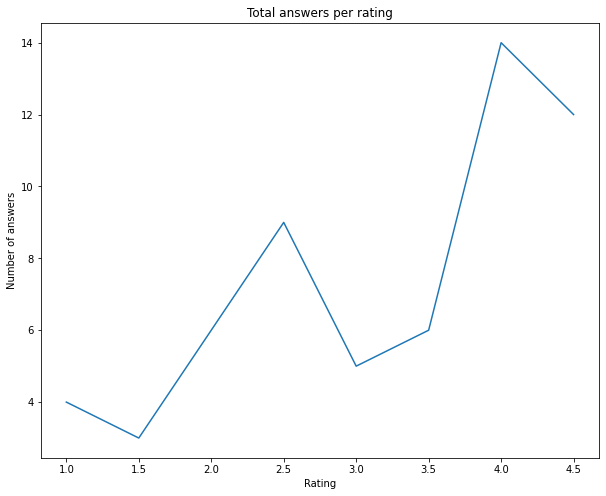

In [330]:
#Total answers per rating
plt.plot(amtres[['Answer.stars', 'WorkerId']].groupby('Answer.stars').count())
plt.title('Total answers per rating');
plt.xlabel('Rating')
plt.ylabel('Number of answers')

#TODO: one line per worker and avg

In [337]:
#Total answers per rating
amtres[['Answer.mistakeSource', 'WorkerId', 'Input.method']].groupby(['Input.method', 'Answer.mistakeSource']).count().reset_index().rename(columns={'WorkerId': 'count', 'Answer.mistakeSource': 'mistakeSource'}).head()

,Input.method,mistakeSource,count
0,dist,artificial,20
1,dist,human,29
2,random,artificial,6
3,random,human,4


In [243]:
#Answers with wrong code
amtres[amtres['Answer.code'] != amtres['Input.ver_code']].head()

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,AutoApprovalDelayInSeconds,Expiration,NumberOfSimilarHITs,LifetimeInSeconds,AssignmentId,WorkerId,AssignmentStatus,AcceptTime,SubmitTime,AutoApprovalTime,ApprovalTime,RejectionTime,RequesterFeedback,WorkTimeInSeconds,LifetimeApprovalRate,Last30DaysApprovalRate,Last7DaysApprovalRate,Input.method,Input.config,Input.source_type,Input.source,Input.target,Input.s_orig,Input.p_orig,Input.o_orig,Input.s,Input.p,Input.o,Input.s_name,Input.p_name,Input.o_name,Input.ver_num,Input.ver_code,Input.s_orig_name,Input.p_orig_name,Input.o_orig_name,Answer.code,Answer.comment,Answer.mistakeSource.artificial,Answer.mistakeSource.correct,Answer.mistakeSource.human,Answer.stars,Approve,Reject,severity
6,33Q5P9PUSPMO5U9272WF957L73TCZQ,3KBQBQZF89BQO3IGU773XS79F4HPAN,Movie data quality rating,You see statements about movies and their indu...,"movies, films, actors, correctness, rate, easy...",$0.00,Tue Jan 12 10:25:03 PST 2021,3,BatchId:305480;OriginalHitTemplateId:921587278;,5400,432000,Tue Jan 19 10:25:03 PST 2021,NaN,NaN,3300DTYQT2HXAKQI6ZOZXKQ0NVPQE8,A1LGQEL2Z68DBP,Submitted,Wed Jan 13 07:38:50 PST 2021,Wed Jan 13 07:39:18 PST 2021,Mon Jan 18 07:39:18 PST 2021,NaN,NaN,NaN,28,0% (0/0),0% (0/0),0% (0/0),dist,"{'amount': {'num': 5}, 'param': {'dist': 1}}",node,http://dbpedia.org/resource/Andorra_(film),http://dbpedia.org/resource/Manuel_Martín_Cuenca,http://dbpedia.org/resource/Andorra_(film),http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Fred_Schepisi,http://dbpedia.org/resource/Manuel_Martín_Cuenca,http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Fred_Schepisi,Manuel Martín Cuenca,director,Fred Schepisi,4-1-4,udd,Andorra (film),director,Fred Schepisi,uMn,Is possible,False,False,True,4.5,NaN,NaN,1
28,3NFWQRSHVEEVHPY78CYRW4CITQRFGF,3KBQBQZF89BQO3IGU773XS79F4HPAN,Movie data quality rating,You see statements about movies and their indu...,"movies, films, actors, correctness, rate, easy...",$0.00,Tue Jan 12 10:25:13 PST 2021,3,BatchId:305480;OriginalHitTemplateId:921587278;,5400,432000,Tue Jan 19 10:25:13 PST 2021,NaN,NaN,3AUQQEL7U5TQO275KRJUIIN4AMV0VR,A1LGQEL2Z68DBP,Submitted,Wed Jan 13 07:45:40 PST 2021,Wed Jan 13 07:46:22 PST 2021,Mon Jan 18 07:46:22 PST 2021,NaN,NaN,NaN,42,0% (0/0),0% (0/0),0% (0/0),dist,"{'amount': {'num': 5}, 'param': {'dist': 5}}",node,http://dbpedia.org/resource/Hughes_brothers,http://dbpedia.org/resource/Coen_brothers,http://dbpedia.org/resource/The_Book_of_Eli,http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Hughes_brothers,http://dbpedia.org/resource/The_Book_of_Eli,http://dbpedia.org/ontology/director,http://dbpedia.org/resource/Coen_brothers,The Book of Eli,director,Coen brothers,4-2-3,_ie,The Book of Eli,director,Hughes brothers,Bie,False director,True,False,False,1.0,NaN,NaN,5
33,36JW4WBR06K9HLTISIG9H4OJ8Q4FHE,3KBQBQZF89BQO3IGU773XS79F4HPAN,Movie data quality rating,You see statements about movies and their indu...,"movies, films, actors, correctness, rate, easy...",$0.00,Tue Jan 12 10:25:14 PST 2021,3,BatchId:305480;OriginalHitTemplateId:921587278;,5400,432000,Tue Jan 19 10:25:14 PST 2021,NaN,NaN,388U7OUMF71YVVQOB7EKHLY1PGI0RY,A1LGQEL2Z68DBP,Submitted,Wed Jan 13 07:36:12 PST 2021,Wed Jan 13 07:36:46 PST 2021,Mon Jan 18 07:36:46 PST 2021,NaN,NaN,NaN,34,0% (0/0),0% (0/0),0% (0/0),random,{'amount': {'num': 5}},relation,http://dbpedia.org/property/backgroundArtist,http://dbpedia.org/ontology/writer,http://dbpedia.org/resource/Looney_Tunes,http://dbpedia.org/property/backgroundArtist,http://dbpedia.org/resource/Warner_Bros._Cartoons,http://dbpedia.org/resource/Looney_Tunes,http://dbpedia.org/ontology/writer,http://dbpedia.org/resource/Warner_Bros._Cartoons,Looney Tunes,writer,Warner Bros. Cartoons,3-4-3,otr,Looney Tunes,backgroundArtist,Warner Bros. Cartoons,oir,Too distinct description,True,False,False,2.5,NaN,NaN,10


In [320]:
#TODO: one table with wrong/correct per worker
amtCodeCheck = pd.DataFrame()

amtCodeCheck[['WorkerId', 'correct']] = amtres[amtres['Answer.code'] != amtres['Input.ver_code']][['WorkerId', 'Answer.stars']].groupby('WorkerId').count().reset_index()
amtCodeCheck[['WorkerId', 'incorrect']] = amtres[amtres['Answer.code'] == amtres['Input.ver_code']][['WorkerId', 'Answer.stars']].groupby('WorkerId').count().reset_index()

amtCodeCheck.head()

,WorkerId,correct,incorrect
0,A11RKRLDED6BEG,56,4
1,A1R3XGPH6EK6G6,6,54
2,ARHWKACQ4T0TW,57,3


In [338]:
#Mean worktime per rating of all wrong codes
amtres[amtres['Answer.code'] != amtres['Input.ver_code']][['Answer.stars', 'WorkTimeInSeconds']].groupby('Answer.stars').mean().reset_index().head()

,Answer.stars,WorkTimeInSeconds
0,1.0,42
1,2.5,34
2,4.5,28


In [322]:
#Correlation excluding random
#amtres.groupby('Input.method')[['Answer.stars', 'WorkTimeInSeconds', 'severity']].corr()

amtres[amtres['Input.method'] == 'dist'][['Answer.stars', 'WorkTimeInSeconds', 'severity']].corr()


,Answer.stars,WorkTimeInSeconds,severity
Answer.stars,1.000000,0.035036,-0.041195
WorkTimeInSeconds,0.035036,1.000000,0.077803
severity,-0.041195,0.077803,1.000000


In [323]:
#Correlation including random
amtres[['Answer.stars', 'WorkTimeInSeconds', 'severity']].corr()

,Answer.stars,WorkTimeInSeconds,severity
Answer.stars,1.000000,0.050979,-0.074890
WorkTimeInSeconds,0.050979,1.000000,0.013477
severity,-0.074890,0.013477,1.000000


In [307]:
amtres[['Answer.stars', 'severity']].groupby('Answer.stars').head()

,Answer.stars,severity
0,1.5,10
1,4.5,10
2,1.0,10
3,3.5,10
4,2.0,10
5,4.0,1
6,4.5,1
7,4.5,1
8,4.5,1
9,1.0,1


Text(0, 0.5, 'Severity')

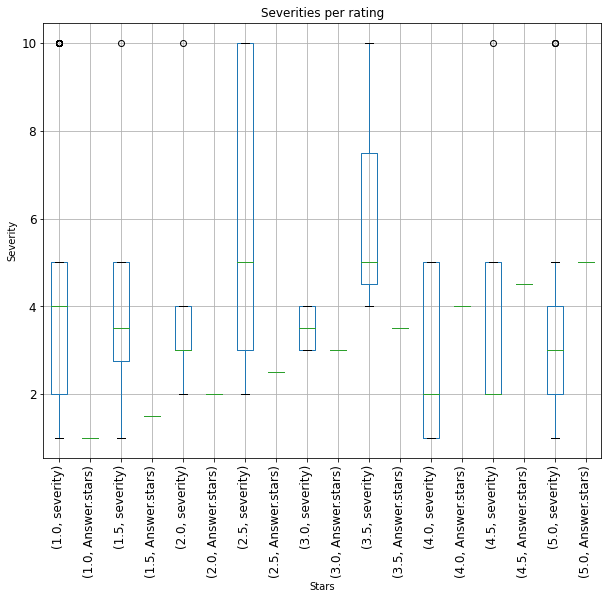

In [325]:
#Severities per rating
amtres[['severity', 'Answer.stars']].groupby('Answer.stars').boxplot(subplots=False, rot=90, fontsize=12)
#amtres[['severity', 'Answer.stars']].boxplot()
plt.title("Severities per rating");
#plt.legend(['a', 'b','c'],  loc="upper left")
plt.xlabel("Stars")
plt.ylabel("Severity")

Text(0, 0.5, 'Rating')

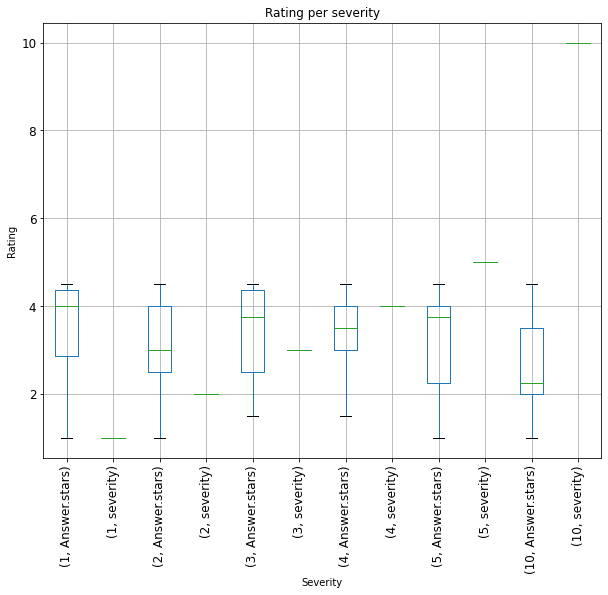

In [264]:
#Rating per severity

amtres[['Answer.stars', 'severity']].groupby('severity').boxplot(subplots=False, rot=90, fontsize=12)
plt.title("Rating per severity");
#plt.legend(['a', 'b','c'],  loc="upper left")
plt.xlabel("Severity")
plt.ylabel("Rating")

Text(0, 0.5, 'Worktime [s]')

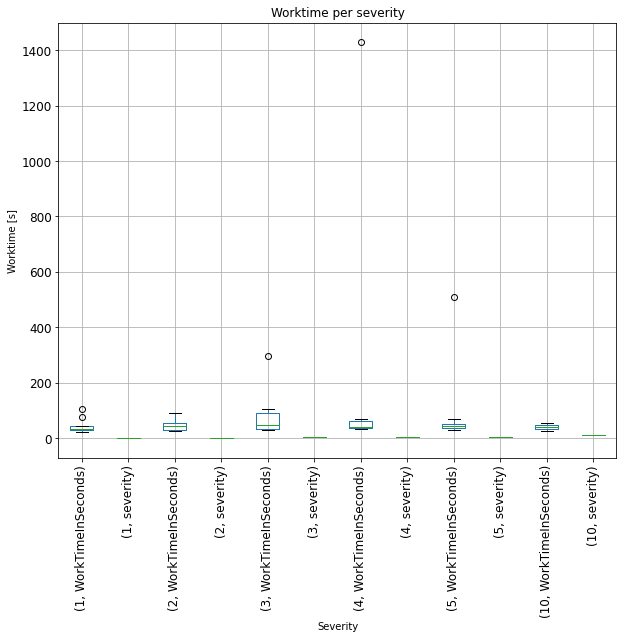

In [273]:
#Worktime per severity of intentionally wrong codes
amtres[['WorkTimeInSeconds', 'severity']].groupby('severity').boxplot(subplots=False, rot=90, fontsize=12)
plt.title("Worktime per severity");
#plt.legend(['a', 'b','c'],  loc="upper left")
plt.xlabel("Severity")
plt.ylabel("Worktime [s]")

In [ ]:
#Set accept/reject for amt answers and export

#Reject everything with wrong codes


#Reject obviously wrong data
#TODO: how will we define this? Just ignore it? Recognise correct statements

#Export file


## Check dictionary quality

In [ ]:
#Compare all dictionaries
dicts = {"gn": gn, "gw1": gw1, "gw3": gw3}

for i in dicts:
    dic = dicts[i]
    
    #Minus means arrow from R to L
    hasCapital = dic["tokyo"] - dic["japan"]
    isCapitalOf = dic["japan"] - dic["tokyo"]
    
    #Calculate results of relation
    est_france = dic["paris"] + isCapitalOf
    est_paris = dic["france"] + hasCapital
    
    print(f"Dictionary: {i}")
    print(f"est_France to France: {dic.cosine_similarities(est_france, [dic['france']])}")
    print(f"est_Paris to Paris: {dic.cosine_similarities(est_paris, [dic['paris']])}")
    print(f"est_France to Paris: {dic.cosine_similarities(est_france, [dic['paris']])}")
    print(f"est_Paris to France: {dic.cosine_similarities(est_paris, [dic['france']])}")
    print(f"Paris to France: {dic.cosine_similarities(dic['paris'], [dic['france']])}")
    print(f"\n")


## Inversion test

In [ ]:
print(f"Similarity: {wv.cosine_similarities(wv['white'], [wv['black']])[0]}\n")

print("Inverted node 'white':")
for d in wv.similar_by_vector(vector = -1*wv['white']):
    print(f"Distance of '{d[0]}' to !white: {d[1]}")

## Currently unused

# Comments

In [ ]:
#TODO: for all appends: 
#https://stackoverflow.com/questions/50501787/python-pandas-user-warning-sorting-because-non-concatenation-axis-is-not-aligne

#TODO: random seeds

#TODO: check for TODOs

In [ ]:
#Returns percent of ambiguity in the graph
def calculateAmbiguity(fullVectors, nodeVectors, relationVectors):
    #cFullVectors = fullVectors.copy()
    #cNodeVectors = nodeVectors.copy()
    #cRelationVectors = relationVectors.copy()
    
    #####for relations#####
    
    #group by relation type
        #cross product group with itself
        #apply(..) to calculate distance between both r_vec
        #relation_distance = mean of all distances
    #ambiguity = average weighted by count(all relation_distances)
    #=> ambiguity values from -1..1 where 1 is the least ambiguous

#     def helper1(grp):
#         #returns the relation_distance for each group

#         group = grp.copy().reset_index(drop=False)
#         logger.info(f"Group ({len(group)}):\n{group['p'].iloc[0]}\nColumns ({len(group.columns)}):\n{group.columns}\n")
#         logger.info(f"{group}")
        
#         out = group.apply(helper2, axis=1)
#         logger.info(f"Out:\n{out}\n\n\n\n\n\n\n\n\n")
        
#         return np.mean(out)
    
#     def helper2(row):
#         #returns the relation_distances for one group
#         logger.info(f"Row: {row['p']}")
        
#         r_vecs = cFullVectors[cFullVectors['p'] == row['p']]['r_vec']
#         logger.info(f"r_vecs ({len(r_vecs)})")
        
#         sims = wv.cosine_similarities(row['r_vec'], r_vecs)
        
#         #returns the relation_distance for one row
#         out = np.mean(sims)
        
#         return out
         
        
    #Remove unwanted entries
    #cFullVectors = cFullVectors[cFullVectors['is_zero_vector_relation'] == False].dropna(subset=['r_vec']).reset_index(drop=True)
    
    #Broken because of https://github.com/pandas-dev/pandas/pull/29131
    #relation_distances = fullVectors.groupby('p').apply(helper1)
    
    #Workaround
    #relation_distances = cRelationVectors.apply(lambda row: helper1(fullVectors[fullVectors['p'] == row['relation']]), axis=1)
    
    #print(relation_distances)
    
    
    ###2nd approach
#     print(f"Relation Vectors:\n{cRelationVectors}")
    
#     row = cRelationVectors.iloc[0]
#     print(f"Row: {row}")
#     print(f"Row.vec:\n{row['vec']}")
#     print(f"r_vecs:\n{list(cFullVectors[cFullVectors['p'] == row['relation']]['r_vec'])}")
#     print(f"Result:\n{wv.cosine_similarities(row['vec'], list(cFullVectors[cFullVectors['p'] == row['relation']]['r_vec']))}")
    
    #cRelationVectors['mean_dist'] = cRelationVectors.apply(lambda row: np.mean(wv.cosine_similarities(row['vec'], list(cFullVectors[cFullVectors['p'] == row['relation']]['r_vec']))), axis=1)
    
    weights = relationVectors['total'] - relationVectors['lost'] - relationVectors['zero_vector']
    relAmbig = np.average(relationVectors['mean_dist'], weights=weights)
    
    #####for nodes (improved)#####
    
    #for node in nodeVectors:
        #node_estimate = average weighted by relations dist to mean(all connected nodes + their relation to node)
    #ambiguity = average weighted by count of (distance(node_estimate, node))
    #=> ambiguity values from -1..1 where 1 is the least ambiguous
    
    weights = nodeVectors['total']
    nodeAmbig = np.average(nodeVectors['est_dist'], weights=weights)
    
    #bad quality of all nodes
    #-> all relation vectors will have high average dist to mean
    
    #bad quality of all relations
    #-> all relation vectors will have high average dist to mean
    
    #bad quality of some nodes
    #-> node_estimate slightly wrong but better if many nodes
    
    #bad quality of some relations
    #-> node_estimate very slightly wrong but better if many nodes and high relation dist to mean
    
    #perfect quality
    #-> node_estimate = node and ambiguity = 1
    
    #do strongly connected nodes influence the outcome more? (they should)
    #-> yes, they are included in more node_estimates
    
    #node and relation are included in each others calculations equally (=once) and only their means are used?
    #-> yes
    
    
    ##final composition & transformation
    #mean of ambiguities of nodes and vectors, weight by nodes 2:1 relation
    totAmbig = np.average([relAmbig, nodeAmbig], weights=[2, 1])
    
    #transform -1..1 where 1 is the least ambiguous to 0..1 where 1 is the most ambiguous
    return 1-((1+totAmbig)/2)

In [ ]:
data = []
data += [['tokyo', wv['berlin'], 1]]
data += [['tokyo', wv['tokyo'], 2]]
data += [['vienna', wv['vienna'], 3]]
df2 = pd.DataFrame(data, columns=['node', 'vec', 'num'])

df2.head()

In [ ]:
data = []
data += [['tokyo', wv['berlin'], 1]]
data += [['tokyo', wv['tokyo'], 2]]
data += [['vienna', wv['vienna'], 3]]
df2 = pd.DataFrame(data, columns=['node', 'vec', 'num'])


df2[['vec2', 'vec3']] = df2.apply(lambda row: pd.Series([toVector(row['node']), None]), axis=1)

df2.head()

In [ ]:
#Test mean
df2out = df2.groupby('node').apply(np.mean).reset_index()
df2out['vec'] = df2.groupby('node')['vec'].apply(np.mean).reset_index()['vec']
df2out.head()

In [ ]:
#NaN vs None problems
print(f"Python: {float('NaN') is None}")
print(f"Numpy equal(..): {np.equal(float('NaN'), None)}")
print(f"Numpy isnan(..): {np.isnan(float('NaN'))}")
print(f"Pandas isnan(..): {pd.isnull(float('NaN'))}, {pd.isnull(None)}") #Replace python checks with this

In [ ]:
#NaN vs None problems
print(f"Python: {float('NaN') is None}")
print(f"Numpy equal(..): {np.equal(float('NaN'), None)}")
print(f"Numpy isnan(..): {np.isnan(float('NaN'))}")
print(f"Pandas isnan(..): {pd.isnull(float('NaN'))}, {pd.isnull(None)}") #Replace python checks with this

In [ ]:
#Random changes for testing
config = {
    'nodes': {
        'random': [{'amount': {'num': 5}}]
    },
    'relations': {
        'random': [{'amount': {'num': 2}}]
    }
}

In [ ]:
#Complete negative for testing
config = {
    'nodes': {
        'negative': [{'amount': {'perc': 1}}]
    },
    'relations': {
        'negative': [{'amount': {'perc': 1}}]
    }
}

In [ ]:
#Closeness for testing
config = {
    'nodes': {
        'closeness': [{'amount': {'num': 5},
                 'param': {'closeness': 0.2}}]
    },
    'relations': {
        'closeness': [{'amount': {'num': 5},
                 'param': {'closeness': 0.2}}]
    }
}

In [ ]:
#Run imports and define functions, configure the desired result

#Load graph and dictionary
convertedGraph = convertGraph(g)
fullVectors = vectorifyGraph(convertedGraph)
relationVectors, lostRelations = generateRelationVectors(fullVectors)
fullVectors = calculateNodeEstimates(fullVectors, relationVectors)
nodeVectors, lostNodes = generateNodeVectors(fullVectors)

#Check outputs before continuing

#Calculate ambiguity before
ambiguityBefore = calculateAmbiguity(fullVectors, nodeVectors, relationVectors)
logger.info(f"Ambiguity before: {ambiguityBefore}")

In [ ]:
#The ambiguify-function returns vectors according to configured methods
res = ambiguify(config, nodeVectors, relationVectors)

In [ ]:
res.head(10)

In [ ]:
#Insert new node into graph based on one random triple containing the source
g2 = Graph()
additions = populateAdditions(res, g2)

#Calculate ambiguity after:
newFullVectors = fullVectors.copy()

if len(additions) > 0:
    logger.info(f"Adding {len(additions)} additional triples")
    vectorisedAdditions = vectorifyGraph(additions)
    newFullVectors = newFullVectors.append(vectorisedAdditions, ignore_index = True)

newRelationVectors, newLostRelations = generateRelationVectors(newFullVectors)
newFullVectors = calculateNodeEstimates(newFullVectors, newRelationVectors)
newNodeVectors, newLostNodes = generateNodeVectors(newFullVectors)

#Calculate ambiguity after
ambiguityAfter = calculateAmbiguity(newFullVectors, newNodeVectors, newRelationVectors)
logger.info(f"Ambiguity after: {ambiguityAfter}")

logger.info(f"Ambiguity difference: {ambiguityAfter-ambiguityBefore}")



#Save additions from nodes and relations
logger.info(f"Saving files")
f = open("additions.ttl", "wb")
f.write(g2.serialize(format='turtle'))
f.close()

#Save graph with additions
g3 = g+g2
f = open("appendedKG.ttl", "wb")
f.write(g3.serialize(format='turtle'))
f.close()
logger.info(f"Done")

# Comments

In [ ]:
#TODO: for all appends: 
#https://stackoverflow.com/questions/50501787/python-pandas-user-warning-sorting-because-non-concatenation-axis-is-not-aligne

#TODO: random seeds

#TODO: check for TODOs

In [ ]:
#Returns percent of ambiguity in the graph
def calculateAmbiguity(fullVectors, nodeVectors, relationVectors):
    #cFullVectors = fullVectors.copy()
    #cNodeVectors = nodeVectors.copy()
    #cRelationVectors = relationVectors.copy()
    
    #####for relations#####
    
    #group by relation type
        #cross product group with itself
        #apply(..) to calculate distance between both r_vec
        #relation_distance = mean of all distances
    #ambiguity = average weighted by count(all relation_distances)
    #=> ambiguity values from -1..1 where 1 is the least ambiguous

#     def helper1(grp):
#         #returns the relation_distance for each group

#         group = grp.copy().reset_index(drop=False)
#         logger.info(f"Group ({len(group)}):\n{group['p'].iloc[0]}\nColumns ({len(group.columns)}):\n{group.columns}\n")
#         logger.info(f"{group}")
        
#         out = group.apply(helper2, axis=1)
#         logger.info(f"Out:\n{out}\n\n\n\n\n\n\n\n\n")
        
#         return np.mean(out)
    
#     def helper2(row):
#         #returns the relation_distances for one group
#         logger.info(f"Row: {row['p']}")
        
#         r_vecs = cFullVectors[cFullVectors['p'] == row['p']]['r_vec']
#         logger.info(f"r_vecs ({len(r_vecs)})")
        
#         sims = wv.cosine_similarities(row['r_vec'], r_vecs)
        
#         #returns the relation_distance for one row
#         out = np.mean(sims)
        
#         return out
         
        
    #Remove unwanted entries
    #cFullVectors = cFullVectors[cFullVectors['is_zero_vector_relation'] == False].dropna(subset=['r_vec']).reset_index(drop=True)
    
    #Broken because of https://github.com/pandas-dev/pandas/pull/29131
    #relation_distances = fullVectors.groupby('p').apply(helper1)
    
    #Workaround
    #relation_distances = cRelationVectors.apply(lambda row: helper1(fullVectors[fullVectors['p'] == row['relation']]), axis=1)
    
    #print(relation_distances)
    
    
    ###2nd approach
#     print(f"Relation Vectors:\n{cRelationVectors}")
    
#     row = cRelationVectors.iloc[0]
#     print(f"Row: {row}")
#     print(f"Row.vec:\n{row['vec']}")
#     print(f"r_vecs:\n{list(cFullVectors[cFullVectors['p'] == row['relation']]['r_vec'])}")
#     print(f"Result:\n{wv.cosine_similarities(row['vec'], list(cFullVectors[cFullVectors['p'] == row['relation']]['r_vec']))}")
    
    #cRelationVectors['mean_dist'] = cRelationVectors.apply(lambda row: np.mean(wv.cosine_similarities(row['vec'], list(cFullVectors[cFullVectors['p'] == row['relation']]['r_vec']))), axis=1)
    
    weights = relationVectors['total'] - relationVectors['lost'] - relationVectors['zero_vector']
    relAmbig = np.average(relationVectors['mean_dist'], weights=weights)
    
    #####for nodes (improved)#####
    
    #for node in nodeVectors:
        #node_estimate = average weighted by relations dist to mean(all connected nodes + their relation to node)
    #ambiguity = average weighted by count of (distance(node_estimate, node))
    #=> ambiguity values from -1..1 where 1 is the least ambiguous
    
    weights = nodeVectors['total']
    nodeAmbig = np.average(nodeVectors['est_dist'], weights=weights)
    
    #bad quality of all nodes
    #-> all relation vectors will have high average dist to mean
    
    #bad quality of all relations
    #-> all relation vectors will have high average dist to mean
    
    #bad quality of some nodes
    #-> node_estimate slightly wrong but better if many nodes
    
    #bad quality of some relations
    #-> node_estimate very slightly wrong but better if many nodes and high relation dist to mean
    
    #perfect quality
    #-> node_estimate = node and ambiguity = 1
    
    #do strongly connected nodes influence the outcome more? (they should)
    #-> yes, they are included in more node_estimates
    
    #node and relation are included in each others calculations equally (=once) and only their means are used?
    #-> yes
    
    
    ##final composition & transformation
    #mean of ambiguities of nodes and vectors, weight by nodes 2:1 relation
    totAmbig = np.average([relAmbig, nodeAmbig], weights=[2, 1])
    
    #transform -1..1 where 1 is the least ambiguous to 0..1 where 1 is the most ambiguous
    return 1-((1+totAmbig)/2)

In [ ]:
data = []
data += [['tokyo', wv['berlin'], 1]]
data += [['tokyo', wv['tokyo'], 2]]
data += [['vienna', wv['vienna'], 3]]
df2 = pd.DataFrame(data, columns=['node', 'vec', 'num'])

df2.head()

In [ ]:
data = []
data += [['tokyo', wv['berlin'], 1]]
data += [['tokyo', wv['tokyo'], 2]]
data += [['vienna', wv['vienna'], 3]]
df2 = pd.DataFrame(data, columns=['node', 'vec', 'num'])


df2[['vec2', 'vec3']] = df2.apply(lambda row: pd.Series([toVector(row['node']), None]), axis=1)

df2.head()

In [ ]:
#Test mean
df2out = df2.groupby('node').apply(np.mean).reset_index()
df2out['vec'] = df2.groupby('node')['vec'].apply(np.mean).reset_index()['vec']
df2out.head()

In [ ]:
#NaN vs None problems
print(f"Python: {float('NaN') is None}")
print(f"Numpy equal(..): {np.equal(float('NaN'), None)}")
print(f"Numpy isnan(..): {np.isnan(float('NaN'))}")
print(f"Pandas isnan(..): {pd.isnull(float('NaN'))}, {pd.isnull(None)}") #Replace python checks with this